# Libs, Wrappers and Training

In [1]:
import gymnasium as gym
import numpy as np
import torch    
from stable_baselines3 import SAC
from pendulum_env_simple import MuJoCoPendulumEnv
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
env = MuJoCoPendulumEnv() 

Using device: cpu


/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [3]:
def rollout_improved(model, env, n_steps=1000, seed=None, start_angle=None, start_velocity=None):
    """Rollout and collect states and actions from a model.
    
    Args:
        model: Trained RL model
        env: Environment to rollout in
        n_steps: Number of steps to rollout
        seed: Random seed for reproducibility
        start_angle: Initial pendulum angle in radians (None for random)
        start_velocity: Initial pendulum velocity in rad/s (None for random) 
                        0 degree for downward position.
    """
    # Prepare reset options
    reset_options = {}
    if start_angle is not None:
        reset_options["start_angle"] = start_angle
    if start_velocity is not None:
        reset_options["start_velocity"] = start_velocity
    
    # Reset environment with specified options
    if seed is not None: 
        obs, _ = env.reset(seed=seed, options=reset_options if reset_options else None)
    else:
        obs, _ = env.reset(options=reset_options if reset_options else None)
        
    actions = []
    states = []
    for _ in range(n_steps):
        states.append(obs.copy())
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action[0])
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            if seed is not None:
                obs, _ = env.reset(seed=seed + np.random.randint(1000), options=reset_options if reset_options else None)
            else:
                obs, _ = env.reset(options=reset_options if reset_options else None)
    return np.array(states), np.array(actions)

In [4]:
class ActionGaussianNoiseWrapper(gym.Wrapper):
    def __init__(self, env, snr_linear=20.0):
        super().__init__(env)
        self.snr_linear = snr_linear

    def step(self, action):
        # action shape: (1,)
        signal_power = np.mean(action**2) + 1e-8

        # Noise power from SNR definition
        noise_power = signal_power / self.snr_linear
        noise_std = np.sqrt(noise_power)

        noise = np.random.normal(0.0, noise_std, size=action.shape)
        action_noisy = action + noise

        return self.env.step(action_noisy)


## Simple SAC

In [5]:
# Create the base noisy environment (used for all rollouts)
base_env = MuJoCoPendulumEnv()
env_noisy = ActionGaussianNoiseWrapper(base_env, snr_linear=10)
# Train simple SAC on noisy env (no penalty)
model_simple = SAC(
    "MlpPolicy",
    env_noisy,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)
model_simple.learn(total_timesteps=40_000)

## Combined Penalty

In [6]:
class CombinedPenaltyWrapper(gym.Wrapper):
    """
    Combines LPF-based HF penalty with action rate penalty for better noise attenuation.
    """
    def __init__(
        self, 
        env, 
        lambda_hf=0.3,      # HF penalty weight (increased)
        lambda_rate=0.1,    # Action rate penalty weight
        cutoff_hz=5.0,      # Lower cutoff for realistic control bandwidth
        fs=50.0             # Sampling frequency
    ):
        super().__init__(env)
        self.lambda_hf = lambda_hf
        self.lambda_rate = lambda_rate
        self.prev_action = 0.0
        
        # LPF to extract HF component via residual
        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.prev_action = 0.0
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # HF penalty via LPF residual
        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]
        hf_penalty = -self.lambda_hf * u_hf**2
        
        # Action rate penalty
        rate_penalty = -self.lambda_rate * (u - self.prev_action)**2
        self.prev_action = u
        
        reward += hf_penalty + rate_penalty
        
        info['hf_penalty'] = hf_penalty
        info['rate_penalty'] = rate_penalty
        
        return obs, reward, terminated, truncated, info
    
# Create training environment with combined penalty
env_combined = CombinedPenaltyWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,  # Match actual dt=0.02
    lambda_hf=0.3,    # Changed from lambda_lpf to match wrapper definition
    lambda_rate=0.1
)

# Train SAC model
model_combined = SAC("MlpPolicy", env_combined, verbose=1)
# model_combined.learn(total_timesteps=40_000)
print("Combined Penalty model trained!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Combined Penalty model trained!


/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## DM Action

In [7]:
class DMWrapperAction(gym.Wrapper):
    """
     DM-style with lower cutoff, stronger penalty, and better sigmoid parameters.
    """
    def __init__(
        self,
        env,
        fs=50.0,
        cutoff_hz=5.0,         # Lower cutoff
        lambda_penalty=0.5,    # Stronger penalty
        sigmoid_scale=50.0,    # Sharper transition
        energy_bias=0.005,     # Lower threshold
        energy_decay=0.9,      # Faster response
    ):
        super().__init__(env)

        self.lambda_penalty = lambda_penalty
        self.sigmoid_scale = sigmoid_scale
        self.energy_bias = energy_bias
        self.energy_decay = energy_decay

        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

        self.hf_energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.hf_energy = 0.0
        return obs, info

    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)

        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]

        self.hf_energy = (
            self.energy_decay * self.hf_energy
            + (1 - self.energy_decay) * (u_hf ** 2)
        )

        hf_score = 1.0 / (
            1.0 + np.exp(-self.sigmoid_scale * (self.hf_energy - self.energy_bias))
        )

        reward += -self.lambda_penalty * hf_score

        info.update({
            "hf_energy": self.hf_energy,
            "hf_score": hf_score,
            "u_hf": u_hf,
        })

        return obs, reward, terminated, truncated, info
    
# Create training environment with improved DM-style
env_action_dm = DMWrapperAction(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,  # Match actual dt=0.02
    lambda_penalty=3,
    sigmoid_scale=50.0,
    energy_bias=0.005,
    energy_decay=0.9
)

# Train SAC model
model_action_dm = SAC("MlpPolicy", env_action_dm, verbose=1)
model_action_dm.learn(total_timesteps=40_000)
print("Improved DM-style model trained!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Improved DM-style model trained!


## DM State 

In [8]:
class DMWrapperState(gym.Wrapper):
    """
     DM-style with lower cutoff, stronger penalty, and better sigmoid parameters.
     Penalizes high-frequency content in the STATE (angle) rather than action.
    """
    def __init__(
        self,
        env,
        fs=50.0,
        cutoff_hz=5.0,         # Lower cutoff
        lambda_penalty=0.5,    # Stronger penalty
        sigmoid_scale=50.0,    # Sharper transition
        energy_bias=0.005,     # Lower threshold
        energy_decay=0.9,      # Faster response
    ):
        super().__init__(env)

        self.lambda_penalty = lambda_penalty
        self.sigmoid_scale = sigmoid_scale
        self.energy_bias = energy_bias
        self.energy_decay = energy_decay

        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

        self.hf_energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.hf_energy = 0.0
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Penalize high-frequency content in the STATE (first observation dimension - angle)
        s = float(obs[0])

        s_lpf, self.zi = lfilter(self.b, self.a, [s], zi=self.zi)
        s_hf = s - s_lpf[0]

        self.hf_energy = (
            self.energy_decay * self.hf_energy
            + (1 - self.energy_decay) * (s_hf ** 2)
        )

        hf_score = 1.0 / (
            1.0 + np.exp(-self.sigmoid_scale * (self.hf_energy - self.energy_bias))
        )

        reward += -self.lambda_penalty * hf_score

        info.update({
            "hf_energy": self.hf_energy,
            "hf_score": hf_score,
            "s_hf": s_hf,  # Changed from u_hf to s_hf to indicate state
        })

        return obs, reward, terminated, truncated, info
    
# Create training environment with improved DM-style for STATE penalty
env_state_dm = DMWrapperState(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,
    lambda_penalty=0.5,    # Much lower penalty
    sigmoid_scale=20.0,    # Gentler transition  
    energy_bias=0.02,      # Higher threshold
    energy_decay=0.95      # Slower response
)

# Train SAC model
model_state_dm = SAC("MlpPolicy", env_state_dm, verbose=1)
model_state_dm.learn(total_timesteps=40_000)
print("State DM-style model trained!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
State DM-style model trained!


# Rollout and Evalute

In [9]:
# Create separate evaluation environments with different seeds to avoid data leakage
rollout_env_simple = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)
rollout_env_combined = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10) 
rollout_env_action_dm = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)
rollout_env_state_dm = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)

# Use same seed for all evaluations to ensure fair comparison
eval_seed = 12345

# Rollout all models on separate environments with same seed
print("Rolling out Simple SAC model (baseline)...")
states_simple, actions_simple = rollout_improved(model_simple, rollout_env_simple, start_angle=0.0, start_velocity=0.0)

print("Rolling out Combined Penalty model...")
states_combined, actions_combined = rollout_improved(model_combined, rollout_env_combined, start_angle=0.0, start_velocity=0.0)

print("Rolling out Action DM-style model...")
states_action_dm, actions_action_dm = rollout_improved(model_action_dm, rollout_env_action_dm, start_angle=0.0, start_velocity=0.0)

print("Rolling out State DM-style model...")
states_state_dm, actions_state_dm = rollout_improved(model_state_dm, rollout_env_state_dm, start_angle=0.0, start_velocity=0.0)

print("All rollouts complete!")
print(f"Data shapes:")
print(f"  Simple (baseline): states {states_simple.shape}, actions {actions_simple.shape}")
print(f"  Combined Penalty: states {states_combined.shape}, actions {actions_combined.shape}")
print(f"  Action DM: states {states_action_dm.shape}, actions {actions_action_dm.shape}")
print(f"  State DM: states {states_state_dm.shape}, actions {actions_state_dm.shape}")

Rolling out Simple SAC model (baseline)...
Rolling out Combined Penalty model...
Rolling out Action DM-style model...
Rolling out State DM-style model...
All rollouts complete!
Data shapes:
  Simple (baseline): states (1000, 3), actions (1000,)
  Combined Penalty: states (1000, 3), actions (1000,)
  Action DM: states (1000, 3), actions (1000,)
  State DM: states (1000, 3), actions (1000,)


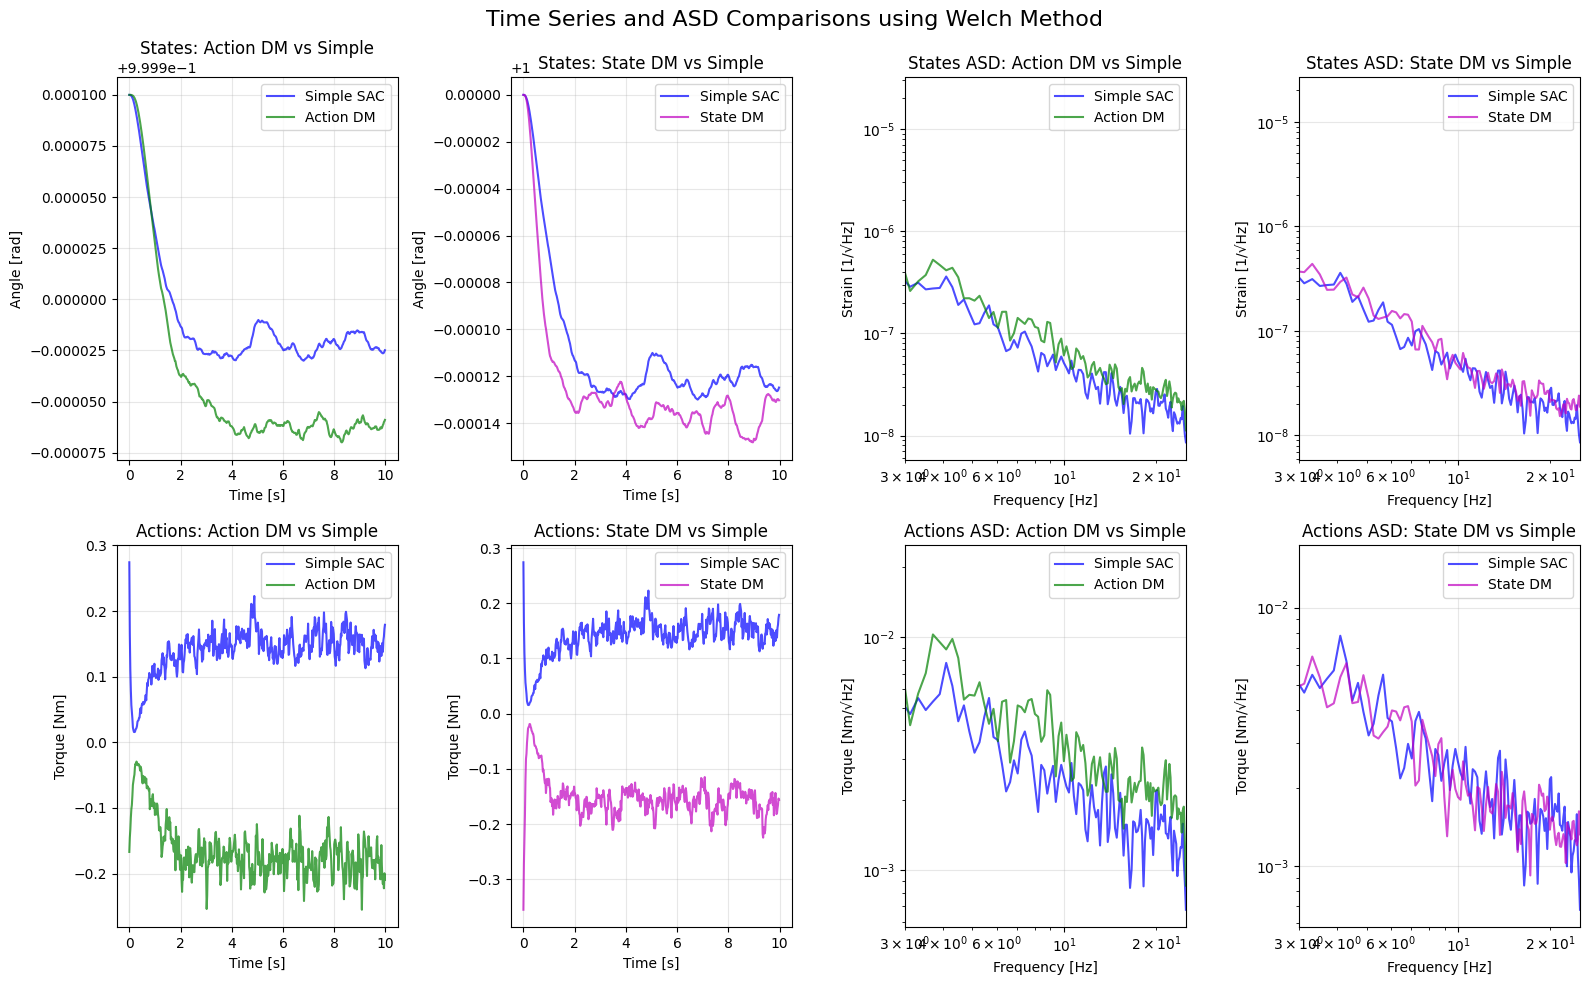

In [10]:
from scipy.signal import welch

# Create 2x4 subplot for time series and ASD comparisons
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Time Series and ASD Comparisons using Welch Method', fontsize=16)

# Sampling frequency and time vector
fs = 50.0
dt = 1.0 / fs
n_steps = len(states_simple)
time = np.arange(n_steps) * dt

# ============ TIME SERIES PLOTS ============
# Top row - States time series
axes[0, 0].plot(time[:500], states_simple[:500, 0], 'b-', label='Simple SAC', alpha=0.7)
axes[0, 0].plot(time[:500], states_action_dm[:500, 0], 'g-', label='Action DM', alpha=0.7)
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Angle [rad]')
axes[0, 0].set_title('States: Action DM vs Simple')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time[:500], states_simple[:500, 0], 'b-', label='Simple SAC', alpha=0.7)
axes[0, 1].plot(time[:500], states_state_dm[:500, 0], 'm-', label='State DM', alpha=0.7)
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Angle [rad]')
axes[0, 1].set_title('States: State DM vs Simple')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom row - Actions time series
axes[1, 0].plot(time[:500], actions_simple[:500], 'b-', label='Simple SAC', alpha=0.7)
axes[1, 0].plot(time[:500], actions_action_dm[:500], 'g-', label='Action DM', alpha=0.7)
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Torque [Nm]')
axes[1, 0].set_title('Actions: Action DM vs Simple')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(time[:500], actions_simple[:500], 'b-', label='Simple SAC', alpha=0.7)
axes[1, 1].plot(time[:500], actions_state_dm[:500], 'm-', label='State DM', alpha=0.7)
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Torque [Nm]')
axes[1, 1].set_title('Actions: State DM vs Simple')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ============ ASD PLOTS (Amplitude Spectral Density) ============
# Calculate PSDs for remaining models
freqs_states_simple, psd_states_simple = welch(states_simple[:, 0], fs=fs, nperseg=256)
freqs_states_action_dm, psd_states_action_dm = welch(states_action_dm[:, 0], fs=fs, nperseg=256)
freqs_states_state_dm, psd_states_state_dm = welch(states_state_dm[:, 0], fs=fs, nperseg=256)

freqs_actions_simple, psd_actions_simple = welch(actions_simple, fs=fs, nperseg=256)
freqs_actions_action_dm, psd_actions_action_dm = welch(actions_action_dm, fs=fs, nperseg=256)
freqs_actions_state_dm, psd_actions_state_dm = welch(actions_state_dm, fs=fs, nperseg=256)

# Convert PSD to ASD (take square root)
asd_states_simple = np.sqrt(psd_states_simple)
asd_states_action_dm = np.sqrt(psd_states_action_dm)
asd_states_state_dm = np.sqrt(psd_states_state_dm)

asd_actions_simple = np.sqrt(psd_actions_simple)
asd_actions_action_dm = np.sqrt(psd_actions_action_dm)
asd_actions_state_dm = np.sqrt(psd_actions_state_dm)

# Right columns - ASD plots
axes[0, 2].loglog(freqs_states_simple, asd_states_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[0, 2].loglog(freqs_states_action_dm, asd_states_action_dm, 'g-', label='Action DM', alpha=0.7)
axes[0, 2].set_xlim(3, 25)
axes[0, 2].set_xlabel('Frequency [Hz]')
axes[0, 2].set_ylabel('Strain [1/√Hz]')
axes[0, 2].set_title('States ASD: Action DM vs Simple')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[0, 3].loglog(freqs_states_simple, asd_states_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[0, 3].loglog(freqs_states_state_dm, asd_states_state_dm, 'm-', label='State DM', alpha=0.7)
axes[0, 3].set_xlim(3, 25)
axes[0, 3].set_xlabel('Frequency [Hz]')
axes[0, 3].set_ylabel('Strain [1/√Hz]')
axes[0, 3].set_title('States ASD: State DM vs Simple')
axes[0, 3].legend()
axes[0, 3].grid(True, alpha=0.3)

axes[1, 2].loglog(freqs_actions_simple, asd_actions_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[1, 2].loglog(freqs_actions_action_dm, asd_actions_action_dm, 'g-', label='Action DM', alpha=0.7)
axes[1, 2].set_xlim(3, 25)
axes[1, 2].set_xlabel('Frequency [Hz]')
axes[1, 2].set_ylabel('Torque [Nm/√Hz]')
axes[1, 2].set_title('Actions ASD: Action DM vs Simple')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

axes[1, 3].loglog(freqs_actions_simple, asd_actions_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[1, 3].loglog(freqs_actions_state_dm, asd_actions_state_dm, 'm-', label='State DM', alpha=0.7)
axes[1, 3].set_xlim(3, 25)
axes[1, 3].set_xlabel('Frequency [Hz]')
axes[1, 3].set_ylabel('Torque [Nm/√Hz]')
axes[1, 3].set_title('Actions ASD: State DM vs Simple')
axes[1, 3].legend()
axes[1, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optuna Hyperparameter Tuning

In [27]:
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

def evaluate_policy(model, env, n_episodes=5, max_steps=1000):
    """Evaluate policy performance with multiple episodes"""
    total_rewards = []
    
    for _ in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        steps = 0
        
        while steps < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
                
        total_rewards.append(episode_reward)
    
    return np.mean(total_rewards)

def objective_dm_action(trial):
    """Objective function for DMWrapperAction hyperparameter optimization"""
    
    # Suggest hyperparameters
    lambda_penalty = trial.suggest_float('lambda_penalty', 0.1, 2.0, log=True)
    sigmoid_scale = trial.suggest_float('sigmoid_scale', 10.0, 100.0, log=True)
    energy_bias = trial.suggest_float('energy_bias', 0.001, 0.05, log=True)
    energy_decay = trial.suggest_float('energy_decay', 0.8, 0.99)
    # Fixed cutoff_hz (not tuned)
    
    try:
        # Create environment with suggested parameters
        env_trial = DMWrapperAction(
            ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
            cutoff_hz=5.0,  # Fixed value
            fs=50.0,
            lambda_penalty=lambda_penalty,
            sigmoid_scale=sigmoid_scale,
            energy_bias=energy_bias,
            energy_decay=energy_decay
        )
        
        # Train model with reduced timesteps for faster optimization
        model_trial = SAC("MlpPolicy", env_trial, verbose=0)
        model_trial.learn(total_timesteps=20_000)
        
        # Evaluate performance
        eval_env = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)
        score = evaluate_policy(model_trial, eval_env, n_episodes=3, max_steps=500)
        
        # Clean up
        env_trial.close()
        eval_env.close()
        del model_trial
        
        return score
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return -1000  # Return very low score for failed trials

def objective_dm_state(trial):
    """Objective function for DMWrapperState hyperparameter optimization"""
    
    # Suggest hyperparameters
    lambda_penalty = trial.suggest_float('lambda_penalty', 0.1, 2.0, log=True)
    sigmoid_scale = trial.suggest_float('sigmoid_scale', 10.0, 100.0, log=True)
    energy_bias = trial.suggest_float('energy_bias', 0.001, 0.05, log=True)
    energy_decay = trial.suggest_float('energy_decay', 0.8, 0.99)
    # Fixed cutoff_hz (not tuned)
    
    try:
        # Create environment with suggested parameters
        env_trial = DMWrapperState(
            ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
            cutoff_hz=5.0,  # Fixed value
            fs=50.0,
            lambda_penalty=lambda_penalty,
            sigmoid_scale=sigmoid_scale,
            energy_bias=energy_bias,
            energy_decay=energy_decay
        )
        
        # Train model with reduced timesteps for faster optimization
        model_trial = SAC("MlpPolicy", env_trial, verbose=0)
        model_trial.learn(total_timesteps=20_000)
        
        # Evaluate performance
        eval_env = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)
        score = evaluate_policy(model_trial, eval_env, n_episodes=3, max_steps=500)
        
        # Clean up
        env_trial.close()
        eval_env.close()
        del model_trial
        
        return score
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return -1000  # Return very low score for failed trials

print("Optuna optimization functions defined!")
print("Ready to optimize DMWrapperAction and DMWrapperState hyperparameters.")

Optuna optimization functions defined!
Ready to optimize DMWrapperAction and DMWrapperState hyperparameters.


## Optimize DMWrapperAction Parameters

In [28]:
# Optimize DMWrapperAction hyperparameters
print("Starting DMWrapperAction optimization...")
print("This will take some time (approx 10-15 minutes for 30 trials)")

study_action = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name="dm_action_optimization"
)

# Run optimization with limited trials for reasonable runtime
study_action.optimize(objective_dm_action, n_trials=30, timeout=900)  # 15 min timeout

print("DMWrapperAction optimization completed!")
print(f"Best score: {study_action.best_value:.2f}")
print("Best parameters:")
for key, value in study_action.best_params.items():
    print(f"  {key}: {value:.6f}")

# Store best parameters for later use
best_action_params = study_action.best_params

[I 2026-01-06 15:12:15,318] A new study created in memory with name: dm_action_optimization


Starting DMWrapperAction optimization...
This will take some time (approx 10-15 minutes for 30 trials)


[I 2026-01-06 15:14:23,010] Trial 0 finished with value: 476.7048501536386 and parameters: {'lambda_penalty': 0.30710573677773717, 'sigmoid_scale': 89.2718030435363, 'energy_bias': 0.01752410111812814, 'energy_decay': 0.913745111997437}. Best is trial 0 with value: 476.7048501536386.
[I 2026-01-06 15:16:32,485] Trial 1 finished with value: 417.0269366705654 and parameters: {'lambda_penalty': 0.1595823775294975, 'sigmoid_scale': 14.321698289111517, 'energy_bias': 0.001255111517297384, 'energy_decay': 0.9645734676972377}. Best is trial 0 with value: 476.7048501536386.
[I 2026-01-06 15:18:37,968] Trial 2 finished with value: 431.37488112286604 and parameters: {'lambda_penalty': 0.6054365855469247, 'sigmoid_scale': 51.059032093947565, 'energy_bias': 0.0010838581269344747, 'energy_decay': 0.9842828719107789}. Best is trial 0 with value: 476.7048501536386.
[I 2026-01-06 15:20:41,101] Trial 3 finished with value: 453.8206530376635 and parameters: {'lambda_penalty': 1.2106896936002165, 'sigmoi

DMWrapperAction optimization completed!
Best score: 476.81
Best parameters:
  lambda_penalty: 0.248787
  sigmoid_scale: 33.477763
  energy_bias: 0.005418
  energy_decay: 0.855334


## Optimize DMWrapperState Parameters

In [29]:
# Optimize DMWrapperState hyperparameters
print("Starting DMWrapperState optimization...")
print("This will take some time (approx 10-15 minutes for 30 trials)")

study_state = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name="dm_state_optimization"
)

# Run optimization with limited trials for reasonable runtime
study_state.optimize(objective_dm_state, n_trials=30, timeout=900)  # 15 min timeout

print("DMWrapperState optimization completed!")
print(f"Best score: {study_state.best_value:.2f}")
print("Best parameters:")
for key, value in study_state.best_params.items():
    print(f"  {key}: {value:.6f}")

# Store best parameters for later use
best_state_params = study_state.best_params

[I 2026-01-06 15:28:56,725] A new study created in memory with name: dm_state_optimization


Starting DMWrapperState optimization...
This will take some time (approx 10-15 minutes for 30 trials)


[I 2026-01-06 15:31:08,798] Trial 0 finished with value: 458.41809563235694 and parameters: {'lambda_penalty': 0.30710573677773717, 'sigmoid_scale': 89.2718030435363, 'energy_bias': 0.01752410111812814, 'energy_decay': 0.913745111997437}. Best is trial 0 with value: 458.41809563235694.
[I 2026-01-06 15:33:26,161] Trial 1 finished with value: 408.2639725975532 and parameters: {'lambda_penalty': 0.1595823775294975, 'sigmoid_scale': 14.321698289111517, 'energy_bias': 0.001255111517297384, 'energy_decay': 0.9645734676972377}. Best is trial 0 with value: 458.41809563235694.
[I 2026-01-06 15:35:39,904] Trial 2 finished with value: 472.1874182096752 and parameters: {'lambda_penalty': 0.6054365855469247, 'sigmoid_scale': 51.059032093947565, 'energy_bias': 0.0010838581269344747, 'energy_decay': 0.9842828719107789}. Best is trial 2 with value: 472.1874182096752.
[I 2026-01-06 15:37:55,899] Trial 3 finished with value: 468.24349038673034 and parameters: {'lambda_penalty': 1.2106896936002165, 'sig

DMWrapperState optimization completed!
Best score: 472.19
Best parameters:
  lambda_penalty: 0.605437
  sigmoid_scale: 51.059032
  energy_bias: 0.001084
  energy_decay: 0.984283


## Visualization and Analysis of Optimization Results

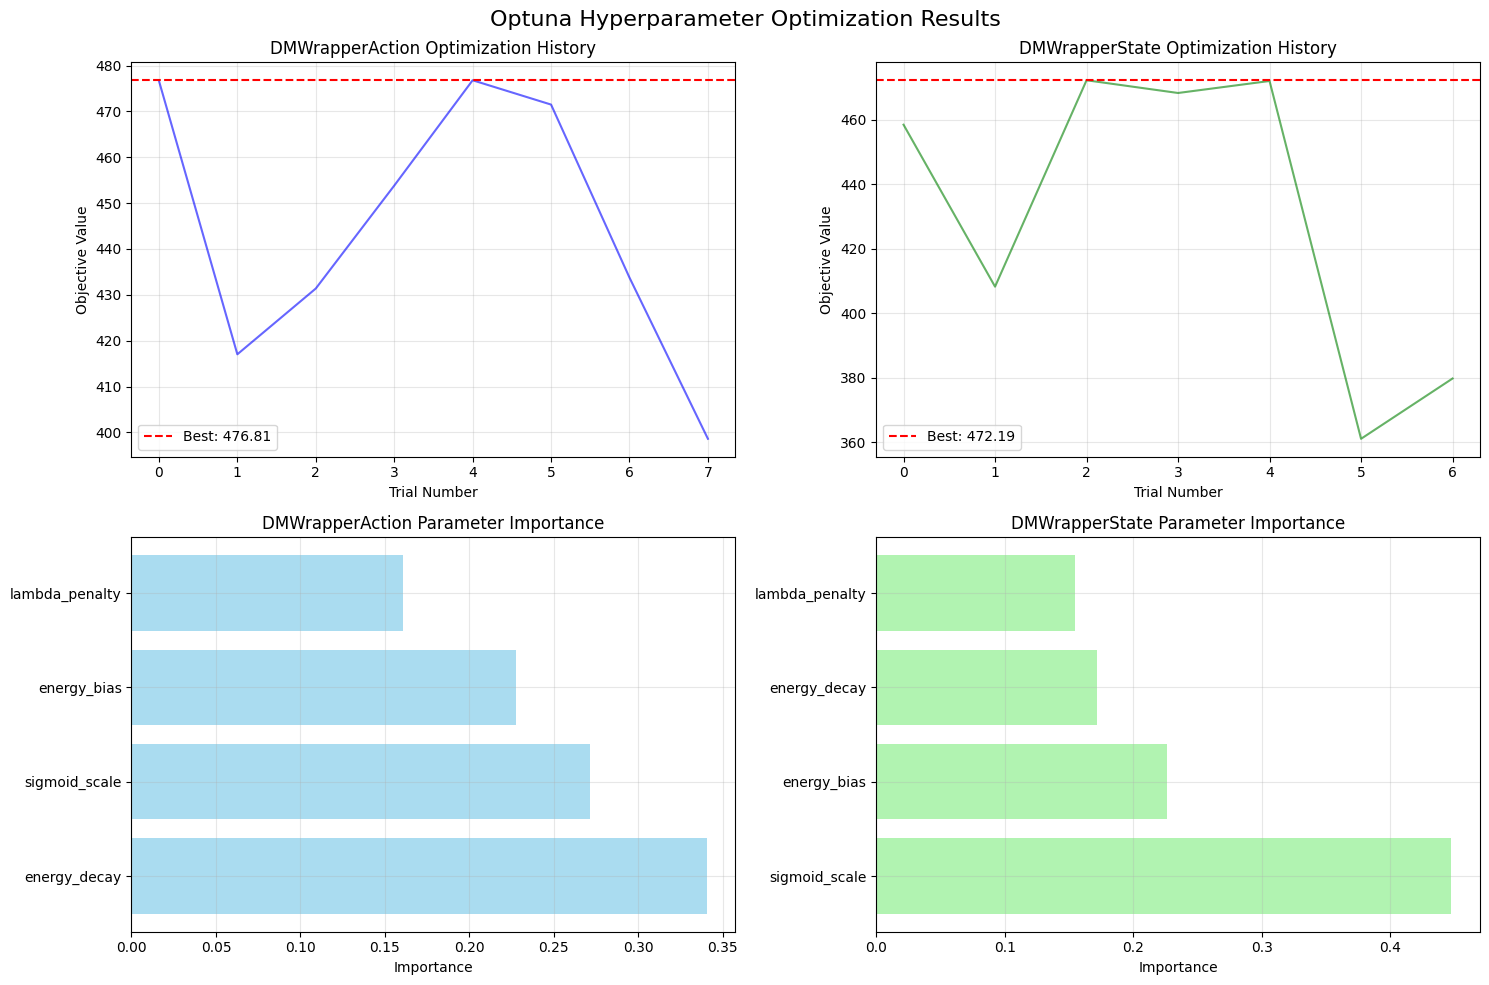


OPTIMIZATION SUMMARY
DMWrapperAction - Best Score: 476.81
Best Action Parameters:
  lambda_penalty: 0.248787
  sigmoid_scale: 33.477763
  energy_bias: 0.005418
  energy_decay: 0.855334

DMWrapperState - Best Score: 472.19
Best State Parameters:
  lambda_penalty: 0.605437
  sigmoid_scale: 51.059032
  energy_bias: 0.001084
  energy_decay: 0.984283


In [30]:
# Visualize optimization results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Optuna Hyperparameter Optimization Results', fontsize=16)

# Plot optimization history for Action wrapper
trial_numbers_action = [trial.number for trial in study_action.trials]
trial_values_action = [trial.value for trial in study_action.trials if trial.value is not None]
trial_numbers_action = trial_numbers_action[:len(trial_values_action)]

axes[0, 0].plot(trial_numbers_action, trial_values_action, 'b-', alpha=0.6)
axes[0, 0].axhline(y=study_action.best_value, color='r', linestyle='--', label=f'Best: {study_action.best_value:.2f}')
axes[0, 0].set_xlabel('Trial Number')
axes[0, 0].set_ylabel('Objective Value')
axes[0, 0].set_title('DMWrapperAction Optimization History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot optimization history for State wrapper
trial_numbers_state = [trial.number for trial in study_state.trials]
trial_values_state = [trial.value for trial in study_state.trials if trial.value is not None]
trial_numbers_state = trial_numbers_state[:len(trial_values_state)]

axes[0, 1].plot(trial_numbers_state, trial_values_state, 'g-', alpha=0.6)
axes[0, 1].axhline(y=study_state.best_value, color='r', linestyle='--', label=f'Best: {study_state.best_value:.2f}')
axes[0, 1].set_xlabel('Trial Number')
axes[0, 1].set_ylabel('Objective Value')
axes[0, 1].set_title('DMWrapperState Optimization History')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Parameter importance plot for Action wrapper
try:
    param_importance_action = optuna.importance.get_param_importances(study_action)
    params_action = list(param_importance_action.keys())
    importance_action = list(param_importance_action.values())
    
    axes[1, 0].barh(params_action, importance_action, color='skyblue', alpha=0.7)
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('DMWrapperAction Parameter Importance')
    axes[1, 0].grid(True, alpha=0.3)
except:
    axes[1, 0].text(0.5, 0.5, 'Not enough trials\nfor importance analysis', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('DMWrapperAction Parameter Importance')

# Parameter importance plot for State wrapper
try:
    param_importance_state = optuna.importance.get_param_importances(study_state)
    params_state = list(param_importance_state.keys())
    importance_state = list(param_importance_state.values())
    
    axes[1, 1].barh(params_state, importance_state, color='lightgreen', alpha=0.7)
    axes[1, 1].set_xlabel('Importance')
    axes[1, 1].set_title('DMWrapperState Parameter Importance')
    axes[1, 1].grid(True, alpha=0.3)
except:
    axes[1, 1].text(0.5, 0.5, 'Not enough trials\nfor importance analysis', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('DMWrapperState Parameter Importance')

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*80)
print("OPTIMIZATION SUMMARY")
print("="*80)
print(f"DMWrapperAction - Best Score: {study_action.best_value:.2f}")
print("Best Action Parameters:")
for key, value in best_action_params.items():
    print(f"  {key}: {value:.6f}")

print(f"\nDMWrapperState - Best Score: {study_state.best_value:.2f}")
print("Best State Parameters:")
for key, value in best_state_params.items():
    print(f"  {key}: {value:.6f}")
print("="*80)

## Train Models with Optimized Parameters

In [33]:
# Train final models with optimized hyperparameters
print("Training optimized models with full timesteps...")

# Create optimized DMWrapperAction environment
env_action_optimized = DMWrapperAction(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=10.0,  # Fixed value (not optimized)
    fs=50.0,
    lambda_penalty=best_action_params['lambda_penalty'],
    sigmoid_scale=best_action_params['sigmoid_scale'],
    energy_bias=best_action_params['energy_bias'],
    energy_decay=best_action_params['energy_decay']
)

# Train optimized Action model
model_action_optimized = SAC("MlpPolicy", env_action_optimized, verbose=1)
model_action_optimized.learn(total_timesteps=40_000)

print("Optimized DMWrapperAction model trained!")

# Create optimized DMWrapperState environment
env_state_optimized = DMWrapperState(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=10.0,  # Fixed value (not optimized)
    fs=50.0,
    lambda_penalty=best_state_params['lambda_penalty'],
    sigmoid_scale=best_state_params['sigmoid_scale'],
    energy_bias=best_state_params['energy_bias'],
    energy_decay=best_state_params['energy_decay']
)

# Train optimized State model
model_state_optimized = SAC("MlpPolicy", env_state_optimized, verbose=1)
model_state_optimized.learn(total_timesteps=40_000)

print("Optimized DMWrapperState model trained!")

# Evaluate optimized models
print("\nEvaluating optimized models...")
eval_env_opt = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)

score_action_opt = evaluate_policy(model_action_optimized, eval_env_opt, n_episodes=10)
score_state_opt = evaluate_policy(model_state_optimized, eval_env_opt, n_episodes=10)

print(f"Optimized Action Model Score: {score_action_opt:.2f}")
print(f"Optimized State Model Score: {score_state_opt:.2f}")

# Compare with original models (if they exist)
try:
    score_action_orig = evaluate_policy(model_action_dm, eval_env_opt, n_episodes=10)
    score_state_orig = evaluate_policy(model_state_dm, eval_env_opt, n_episodes=10)
    
    print(f"\nComparison with original models:")
    print(f"Action - Original: {score_action_orig:.2f}, Optimized: {score_action_opt:.2f}, Improvement: {score_action_opt - score_action_orig:.2f}")
    print(f"State - Original: {score_state_orig:.2f}, Optimized: {score_state_opt:.2f}, Improvement: {score_state_opt - score_state_orig:.2f}")
except:
    print("Original models not available for comparison")

eval_env_opt.close()

Training optimized models with full timesteps...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Optimized DMWrapperAction model trained!
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Optimized DMWrapperState model trained!

Evaluating optimized models...
Optimized Action Model Score: 960.03
Optimized State Model Score: 887.53

Comparison with original models:
Action - Original: 916.24, Optimized: 960.03, Improvement: 43.78
State - Original: 866.39, Optimized: 887.53, Improvement: 21.13


## Rollouts for Optimized Models

In [36]:
# Create separate evaluation environments for optimized models
rollout_env_action_opt = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)
rollout_env_state_opt = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)

# Rollout optimized models using same starting conditions for fair comparison
print("Rolling out Optimized Action DM model...")
states_action_opt, actions_action_opt = rollout_improved(
    model_action_optimized, rollout_env_action_opt, 
    start_angle=0.0, start_velocity=0.0, n_steps=1000
)

print("Rolling out Optimized State DM model...")
states_state_opt, actions_state_opt = rollout_improved(
    model_state_optimized, rollout_env_state_opt, 
    start_angle=0.0, start_velocity=0.0, n_steps=1000
)

print("Optimized model rollouts complete!")
print(f"Data shapes:")
print(f"  Optimized Action DM: states {states_action_opt.shape}, actions {actions_action_opt.shape}")
print(f"  Optimized State DM: states {states_state_opt.shape}, actions {actions_state_opt.shape}")

rollout_env_action_opt.close()
rollout_env_state_opt.close()

Rolling out Optimized Action DM model...
Rolling out Optimized State DM model...
Optimized model rollouts complete!
Data shapes:
  Optimized Action DM: states (1000, 3), actions (1000,)
  Optimized State DM: states (1000, 3), actions (1000,)


## Optimized Models: Time Series and ASD Analysis

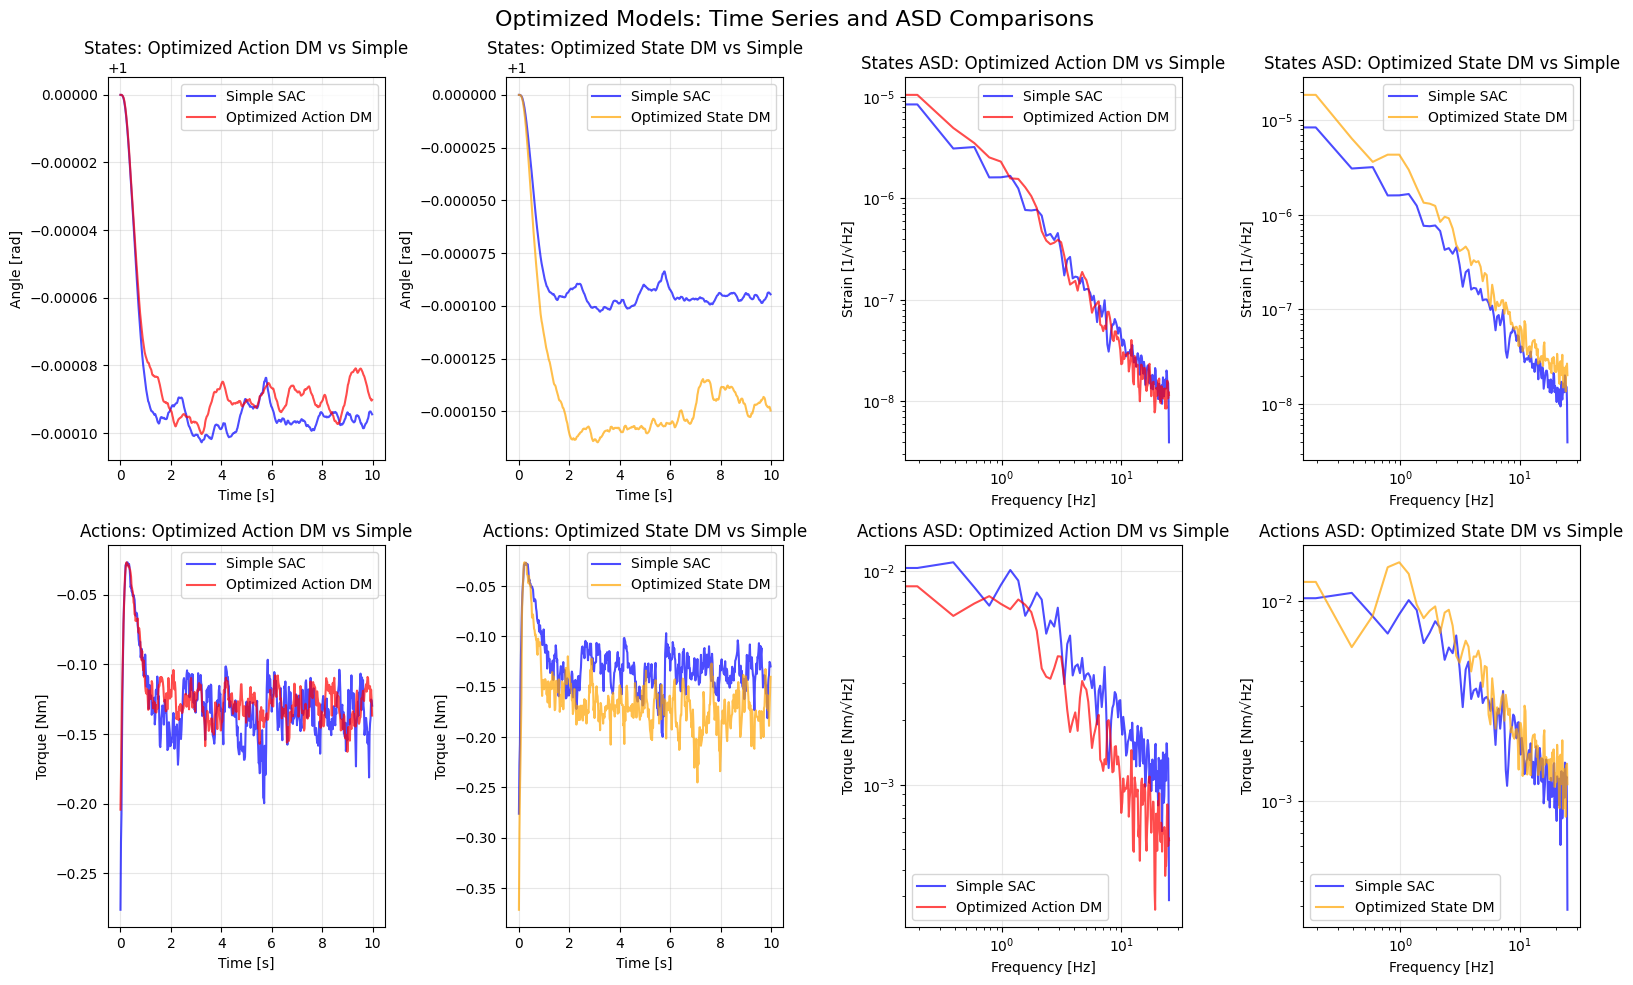

OPTIMIZED MODELS - ASD Analysis Summary:
STATES ASD (1/√Hz):
  Simple SAC (baseline):     0.000000
  Optimized Action DM:       0.000000
  Optimized State DM:        0.000001

ACTIONS ASD (Nm/√Hz):
  Simple SAC (baseline):     0.002536
  Optimized Action DM:       0.001673
  Optimized State DM:        0.003110

IMPROVEMENT vs Simple SAC:
  States - Optimized Action DM: -17.4%
  States - Optimized State DM:  -89.3%
  Actions - Optimized Action DM: +34.0%
  Actions - Optimized State DM:  -22.7%


In [ ]:
# Create 2x4 subplot for optimized models comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Optimized Models: Time Series and ASD Comparisons', fontsize=16)

# Sampling frequency and time vector
fs = 50.0
dt = 1.0 / fs
n_steps = len(states_simple)
time = np.arange(n_steps) * dt

# ============ TIME SERIES PLOTS ============
# Top row - States time series comparisons
axes[0, 0].plot(time[:500], states_simple[:500, 0], 'b-', label='Simple SAC', alpha=0.7)
axes[0, 0].plot(time[:500], states_action_opt[:500, 0], 'r-', label='Optimized Action DM', alpha=0.7)
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Angle [rad]')
axes[0, 0].set_title('Pendulum Angle: Optimized Action DM vs Simple SAC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time[:500], states_simple[:500, 0], 'b-', label='Simple SAC', alpha=0.7)
axes[0, 1].plot(time[:500], states_state_opt[:500, 0], 'orange', label='Optimized State DM', alpha=0.7)
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Angle [rad]')
axes[0, 1].set_title('Pendulum Angle: Optimized State DM vs Simple SAC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom row - Actions time series comparisons
axes[1, 0].plot(time[:500], actions_simple[:500], 'b-', label='Simple SAC', alpha=0.7)
axes[1, 0].plot(time[:500], actions_action_opt[:500], 'r-', label='Optimized Action DM', alpha=0.7)
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Torque [Nm]')
axes[1, 0].set_title('Control Torque: Optimized Action DM vs Simple SAC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(time[:500], actions_simple[:500], 'b-', label='Simple SAC', alpha=0.7)
axes[1, 1].plot(time[:500], actions_state_opt[:500], 'orange', label='Optimized State DM', alpha=0.7)
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Torque [Nm]')
axes[1, 1].set_title('Control Torque: Optimized State DM vs Simple SAC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ============ ASD PLOTS (Amplitude Spectral Density) ============
# Calculate PSDs for optimized models
freqs_states_action_opt, psd_states_action_opt = welch(states_action_opt[:, 0], fs=fs, nperseg=256)
freqs_states_state_opt, psd_states_state_opt = welch(states_state_opt[:, 0], fs=fs, nperseg=256)

freqs_actions_action_opt, psd_actions_action_opt = welch(actions_action_opt, fs=fs, nperseg=256)
freqs_actions_state_opt, psd_actions_state_opt = welch(actions_state_opt, fs=fs, nperseg=256)

# Convert PSD to ASD for optimized models
asd_states_action_opt = np.sqrt(psd_states_action_opt)
asd_states_state_opt = np.sqrt(psd_states_state_opt)

asd_actions_action_opt = np.sqrt(psd_actions_action_opt)
asd_actions_state_opt = np.sqrt(psd_actions_state_opt)

# Right columns - ASD plots for optimized models
axes[0, 2].loglog(freqs_states_simple, asd_states_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[0, 2].loglog(freqs_states_action_opt, asd_states_action_opt, 'r-', label='Optimized Action DM', alpha=0.7)
axes[0, 2].set_xlabel('Frequency [Hz]')
axes[0, 2].set_ylabel('Strain [1/√Hz]')
axes[0, 2].set_title('Angle Noise Spectrum: Optimized Action DM vs Simple SAC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[0, 3].loglog(freqs_states_simple, asd_states_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[0, 3].loglog(freqs_states_state_opt, asd_states_state_opt, 'orange', label='Optimized State DM', alpha=0.7)
axes[0, 3].set_xlabel('Frequency [Hz]')
axes[0, 3].set_ylabel('Strain [1/√Hz]')
axes[0, 3].set_title('Angle Noise Spectrum: Optimized State DM vs Simple SAC')
axes[0, 3].legend()
axes[0, 3].grid(True, alpha=0.3)

axes[1, 2].loglog(freqs_actions_simple, asd_actions_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[1, 2].loglog(freqs_actions_action_opt, asd_actions_action_opt, 'r-', label='Optimized Action DM', alpha=0.7)
axes[1, 2].set_xlabel('Frequency [Hz]')
axes[1, 2].set_ylabel('Torque [Nm/√Hz]')
axes[1, 2].set_title('Torque Noise Spectrum: Optimized Action DM vs Simple SAC')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

axes[1, 3].loglog(freqs_actions_simple, asd_actions_simple, 'b-', label='Simple SAC', alpha=0.7)
axes[1, 3].loglog(freqs_actions_state_opt, asd_actions_state_opt, 'orange', label='Optimized State DM', alpha=0.7)
axes[1, 3].set_xlabel('Frequency [Hz]')
axes[1, 3].set_ylabel('Torque [Nm/√Hz]')
axes[1, 3].set_title('Torque Noise Spectrum: Optimized State DM vs Simple SAC')
axes[1, 3].legend()
axes[1, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics for optimized models
print("OPTIMIZED MODELS - ASD Analysis Summary:")
print("=" * 60)
print("STATES ASD (1/√Hz):")
print(f"  Simple SAC (baseline):     {np.mean(asd_states_simple):.6f}")
print(f"  Optimized Action DM:       {np.mean(asd_states_action_opt):.6f}")
print(f"  Optimized State DM:        {np.mean(asd_states_state_opt):.6f}")
print()
print("ACTIONS ASD (Nm/√Hz):")
print(f"  Simple SAC (baseline):     {np.mean(asd_actions_simple):.6f}")
print(f"  Optimized Action DM:       {np.mean(asd_actions_action_opt):.6f}")
print(f"  Optimized State DM:        {np.mean(asd_actions_state_opt):.6f}")
print()
print("IMPROVEMENT vs Simple SAC:")
states_improvement_action = ((np.mean(asd_states_simple) - np.mean(asd_states_action_opt)) / np.mean(asd_states_simple)) * 100
states_improvement_state = ((np.mean(asd_states_simple) - np.mean(asd_states_state_opt)) / np.mean(asd_states_simple)) * 100
actions_improvement_action = ((np.mean(asd_actions_simple) - np.mean(asd_actions_action_opt)) / np.mean(asd_actions_simple)) * 100
actions_improvement_state = ((np.mean(asd_actions_simple) - np.mean(asd_actions_state_opt)) / np.mean(asd_actions_simple)) * 100

print(f"  States - Optimized Action DM: {states_improvement_action:+.1f}%")
print(f"  States - Optimized State DM:  {states_improvement_state:+.1f}%")
print(f"  Actions - Optimized Action DM: {actions_improvement_action:+.1f}%")
print(f"  Actions - Optimized State DM:  {actions_improvement_state:+.1f}%")
print("=" * 60)

## Before vs After Optimization Comparison

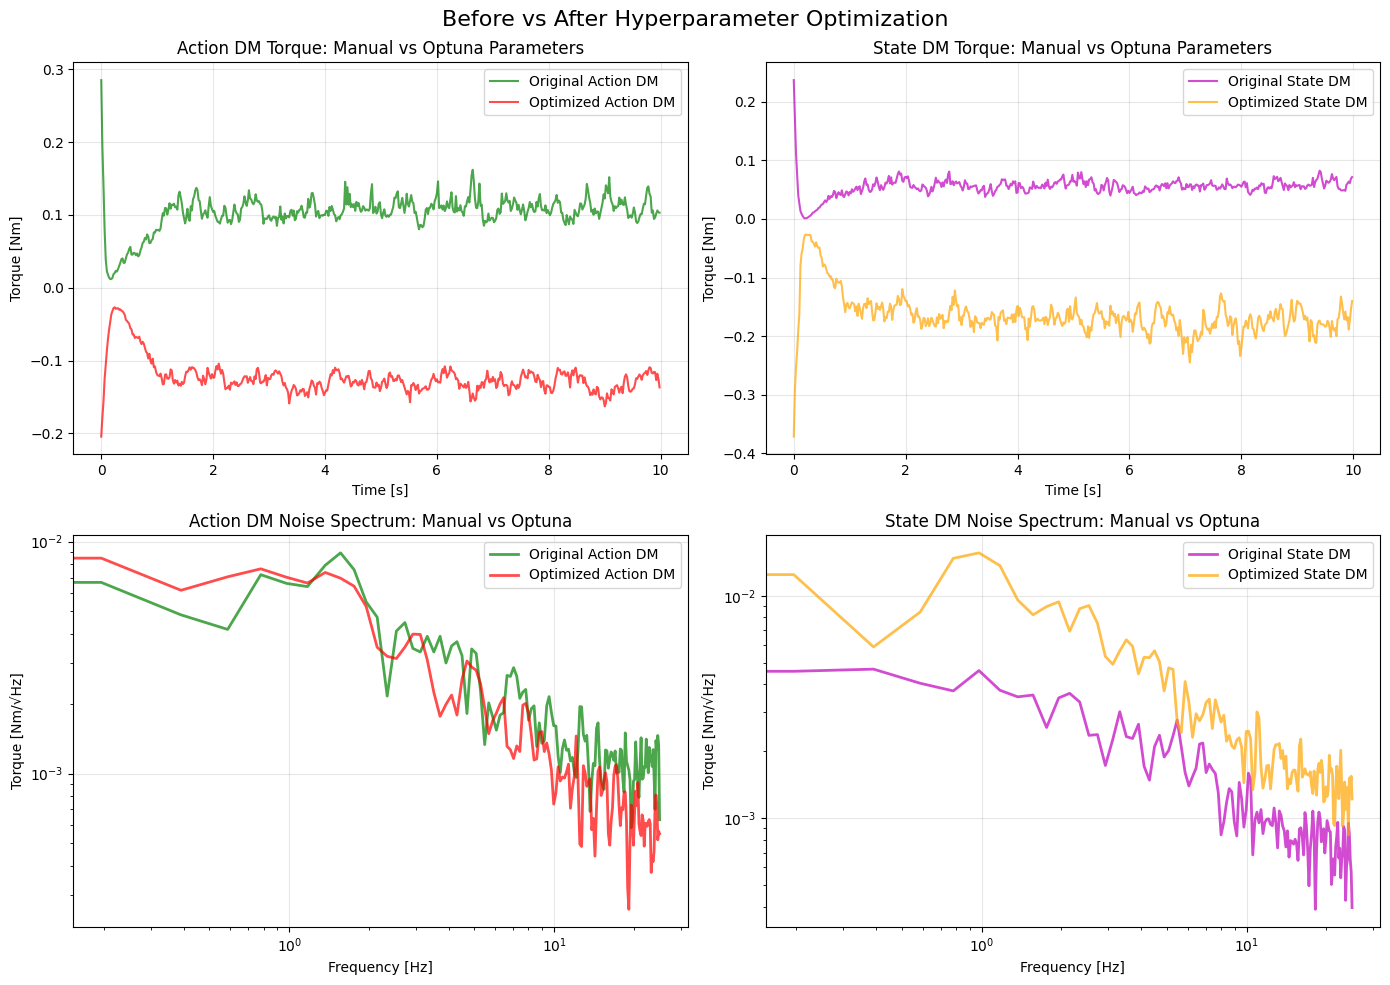

OPTIMIZATION EFFECTIVENESS ANALYSIS:
Parameter Comparison:
----------------------------------------
Action DM - ORIGINAL parameters:
  lambda_penalty: 3.0
  sigmoid_scale: 50.0
  energy_bias: 0.005
  energy_decay: 0.9
  cutoff_hz: 5.0 (fixed)

Action DM - OPTIMIZED parameters:
  lambda_penalty: 0.248787
  sigmoid_scale: 33.477763
  energy_bias: 0.005418
  energy_decay: 0.855334
  cutoff_hz: 5.0 (fixed)

State DM - ORIGINAL parameters:
  lambda_penalty: 0.5
  sigmoid_scale: 20.0
  energy_bias: 0.02
  energy_decay: 0.95
  cutoff_hz: 5.0 (fixed)

State DM - OPTIMIZED parameters:
  lambda_penalty: 0.605437
  sigmoid_scale: 51.059032
  energy_bias: 0.001084
  energy_decay: 0.984283
  cutoff_hz: 5.0 (fixed)

ASD Performance Comparison:
----------------------------------------
Action DM - Original ASD:   0.002045 Nm/√Hz
Action DM - Optimized ASD:  0.001673 Nm/√Hz
Action DM - Improvement:    +18.2%

State DM - Original ASD:    0.001399 Nm/√Hz
State DM - Optimized ASD:   0.003110 Nm/√Hz
State D

In [39]:
# Direct comparison: Original vs Optimized models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Before vs After Hyperparameter Optimization', fontsize=16)

# Time vector for plotting
time = np.arange(500) * dt  # First 500 steps for clarity

# Action DM: Original vs Optimized
axes[0, 0].plot(time, actions_action_dm[:500], 'g-', label='Original Action DM', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(time, actions_action_opt[:500], 'r-', label='Optimized Action DM', alpha=0.7, linewidth=1.5)
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Torque [Nm]')
axes[0, 0].set_title('Action DM Torque: Manual vs Optuna Parameters')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# State DM: Original vs Optimized
axes[0, 1].plot(time, actions_state_dm[:500], 'm-', label='Original State DM', alpha=0.7, linewidth=1.5)
axes[0, 1].plot(time, actions_state_opt[:500], 'orange', label='Optimized State DM', alpha=0.7, linewidth=1.5)
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Torque [Nm]')
axes[0, 1].set_title('State DM Torque: Manual vs Optuna Parameters')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ASD Comparison: Action DM
axes[1, 0].loglog(freqs_actions_action_dm, asd_actions_action_dm, 'g-', 
                  label='Original Action DM', alpha=0.7, linewidth=2)
axes[1, 0].loglog(freqs_actions_action_opt, asd_actions_action_opt, 'r-', 
                  label='Optimized Action DM', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('Frequency [Hz]')
axes[1, 0].set_ylabel('Torque [Nm/√Hz]')
axes[1, 0].set_title('Action DM Noise Spectrum: Manual vs Optuna')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ASD Comparison: State DM  
axes[1, 1].loglog(freqs_actions_state_dm, asd_actions_state_dm, 'm-', 
                  label='Original State DM', alpha=0.7, linewidth=2)
axes[1, 1].loglog(freqs_actions_state_opt, asd_actions_state_opt, 'orange', 
                  label='Optimized State DM', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('Frequency [Hz]')
axes[1, 1].set_ylabel('Torque [Nm/√Hz]')
axes[1, 1].set_title('State DM Noise Spectrum: Manual vs Optuna')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative comparison table
print("OPTIMIZATION EFFECTIVENESS ANALYSIS:")
print("=" * 80)
print("Parameter Comparison:")
print("-" * 40)
print("Action DM - ORIGINAL parameters:")
print("  lambda_penalty: 3.0")  
print("  sigmoid_scale: 50.0") 
print("  energy_bias: 0.005")
print("  energy_decay: 0.9")
print("  cutoff_hz: 5.0 (fixed)")
print()
print("Action DM - OPTIMIZED parameters:")
for key, value in best_action_params.items():
    print(f"  {key}: {value:.6f}")
print("  cutoff_hz: 5.0 (fixed)")
print()
print("State DM - ORIGINAL parameters:")
print("  lambda_penalty: 0.5")
print("  sigmoid_scale: 20.0")
print("  energy_bias: 0.02") 
print("  energy_decay: 0.95")
print("  cutoff_hz: 5.0 (fixed)")
print()
print("State DM - OPTIMIZED parameters:")
for key, value in best_state_params.items():
    print(f"  {key}: {value:.6f}")
print("  cutoff_hz: 5.0 (fixed)")
print()
print("ASD Performance Comparison:")
print("-" * 40)
orig_action_asd = np.mean(asd_actions_action_dm)
opt_action_asd = np.mean(asd_actions_action_opt)
orig_state_asd = np.mean(asd_actions_state_dm)
opt_state_asd = np.mean(asd_actions_state_opt)

action_improvement = ((orig_action_asd - opt_action_asd) / orig_action_asd) * 100
state_improvement = ((orig_state_asd - opt_state_asd) / orig_state_asd) * 100

print(f"Action DM - Original ASD:   {orig_action_asd:.6f} Nm/√Hz")
print(f"Action DM - Optimized ASD:  {opt_action_asd:.6f} Nm/√Hz")
print(f"Action DM - Improvement:    {action_improvement:+.1f}%")
print()
print(f"State DM - Original ASD:    {orig_state_asd:.6f} Nm/√Hz")
print(f"State DM - Optimized ASD:   {opt_state_asd:.6f} Nm/√Hz") 
print(f"State DM - Improvement:     {state_improvement:+.1f}%")
print("=" * 80)